### imports

In [1]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import pythonlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### Session helper functions

In [3]:
################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getNeuralTrialNumsFromTrialCodes(sn, trialcodes)


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event][0]
    end_time = dict_event_times[end_event][0]
    
    return start_time, end_time


# return mask array of whether within bounding box
def getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)

    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

## Part 1: export x,y,times,outlier_mask to MATLAB

In [4]:
## LOAD IN SESSION ##

# preprocessed datasets: Diego-230603 (ok), Pancho-221020 (ok), Diego-230626 (primsingrid), Diego-230616 (26 singleprims)
date = 230623
animal = "Pancho"
session = 0

# change to base dir
basedir = "/home/kgg/Desktop/eyetracking_analyses/"
os.chdir(basedir)

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.makedirs(dirn, exist_ok=True)
os.chdir(dirn)

# load session
#MS = load_mult_session_helper(date, animal)
MS = load_mult_session_helper(date, animal, MINIMAL_LOADING=True, spikes_version="kilosort")
sn = MS.SessionsList[session]

Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Pancho*/*230623*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623/Pancho-230623-144906
session:  0
Beh Sessions that exist on this date:  {230623: [(1, 'primsingridfixed6d')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['primsingridfixed6d']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Pancho*/*230623*/**
Found this many paths:
1
---
/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623/Pancho-230623-144906
{'filename_components_hyphened': ['Pancho', '230623', '144906'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Pancho', '/home/kgg/mnt/Freiwald/ltian/recordings/Pancho/230623'], 'basedirs_filenames': ['230623', 'Pancho-230623-144906'], 'filename_final_ext': 'Pancho-230623-144906', 'filename_final_noext': 'Pancho-230623-144906'}
FOu

In [5]:
success_neural_trials = getSuccessfulNeuralTrialNums(sn)
# store valid trialnums
neuraltnums = []
tcodes = []

SAVEMATS=False

# get bounding box
# - format: [[-x, -y], [+x, +y]]. does not save in self
#bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
#print(bounding_box)


# loop thru trials and save xy data
for ntrial in success_neural_trials:
    if SAVEMATS==True:
        # get sampling rate
        t,v,fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

        # get XY smoothed / transformed on eye calibration matrix
        x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)

        # resample x, y, times using integer sampling rate
        fs_new = 200
        stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
        stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
        stroke_resampled = stroke_intp[0]
        x_rs = stroke_resampled[:,0]
        y_rs = stroke_resampled[:,1]
        times_rs = stroke_resampled[:,2]
        
        # save data to be loaded into MATLAB
        fname = "ntrial" + str(ntrial) + ".mat"
        scipy.io.savemat(fname, dict(x=x_rs, y=y_rs, times=times_rs, fs_hz=fs_new))

    # save neuraltnums, tcodes
    neuraltnums.append(ntrial)
    tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))
    



*** RUNNING D.preprocessGood using these params:
['one_to_one_beh_task_strokes']
-- Len of D, before applying this param: one_to_one_beh_task_strokes, ... 708
after: 616


In [6]:
# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# Part 2: after running ClusterFix in MATLAB, load in fixation/saccade times 

In [7]:
# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

In [8]:
# add results to dataframe

mat_vars = ['neuraltrialnum', 'trialcode', 'fs', 'x', 'y', 'times', 'fixation_start_inds',
            'fixation_end_inds', 'fixation_centroids_x', 'fixation_centroids_y', 
            'saccade_start_inds', 'saccade_end_inds']
tmp = []
for i in range(len(mat['RESULTS'][0])):
    neuraltrialnum = mat['RESULTS'][0]['neuraltrialnum'][i][0,0]
    tcode = mat['RESULTS'][0]['trialcode'][i][0]
    fs = mat['RESULTS'][0]['fs'][i][0,0]
    x = mat['RESULTS'][0]['x'][i][0]
    y = mat['RESULTS'][0]['y'][i][0]
    times = mat['RESULTS'][0]['times'][i][0]
    
    # get start, end inds for fixations/saccades
    fixation_start_inds = mat['RESULTS'][0]['fixation_inds'][i][0]
    fixation_end_inds = mat['RESULTS'][0]['fixation_inds'][i][1]
    saccade_start_inds = mat['RESULTS'][0]['saccade_inds'][i][0]
    saccade_end_inds = mat['RESULTS'][0]['saccade_inds'][i][1]
    
    # get centroids x,y
    fixation_centroids_x = mat['RESULTS'][0]['fixation_centroids'][i][0]
    fixation_centroids_y = mat['RESULTS'][0]['fixation_centroids'][i][1]
    
    dat = [neuraltrialnum, tcode, fs, x, y, times, fixation_start_inds, fixation_end_inds,
            fixation_centroids_x, fixation_centroids_y, saccade_start_inds, saccade_end_inds]
    tmp.append({})
    for v, d in zip(mat_vars, dat):
        tmp[-1][v]=d
        
clusterfix_results = pd.DataFrame(tmp, columns=mat_vars)

In [9]:
clusterfix_results

,neuraltrialnum,trialcode,fs,x,y,times,fixation_start_inds,fixation_end_inds,fixation_centroids_x,fixation_centroids_y,saccade_start_inds,saccade_end_inds
0,0,230623-1-1,0.005,"[-199.070316702116, -196.45790299897874, -235....","[-160.06222822861773, -151.7431679277271, -130...","[-1.0054822681489064, -1.0004795857798243, -0....","[7, 50, 106, 144, 211, 311, 347, 458, 582, 623...","[36, 90, 131, 188, 292, 336, 448, 570, 612, 65...","[-302.4144220192319, 19.964435311848217, 393.2...","[-89.97304288217926, -276.5403849012262, -67.1...","[1, 37, 92, 132, 189, 293, 338, 449, 571, 613,...","[6, 48, 104, 143, 210, 310, 346, 457, 581, 622..."
1,1,230623-1-2,0.005,"[-39.669147605668186, -44.60166595965158, -41....","[-40.34315957770101, -44.19316060523777, -41.5...","[-0.9999244627946666, -0.9949217698205517, -0....","[72, 128, 233, 266, 322, 485, 517, 704, 734, 7...","[116, 215, 252, 311, 474, 506, 694, 723, 769, ...","[-91.17992191488068, -47.34983863214683, 425.6...","[-276.0405766506025, -19.73258983986994, -13.4...","[61, 117, 216, 253, 312, 475, 507, 695, 724, 7...","[71, 127, 231, 265, 321, 483, 516, 703, 733, 7..."
2,2,230623-1-3,0.005,"[221.76047699302157, 224.59605422582786, 223.4...","[603.3626197198428, 604.5013155591888, 602.879...","[-1.0003763939032098, -0.9953756701686871, -0....","[4, 30, 83, 150, 198, 273, 391, 694, 732, 770,...","[20, 61, 136, 182, 260, 383, 681, 723, 760, 79...","[226.66415134788824, 339.3404524132671, 60.204...","[604.9438573273927, 650.8361854115512, -106.80...","[22, 62, 138, 184, 261, 385, 683, 724, 761, 79...","[28, 82, 149, 197, 271, 390, 693, 731, 769, 80..."
3,3,230623-1-4,0.005,"[604.1637956482454, 540.2387939205607, 480.615...","[262.12316290370387, 234.55685554706392, 215.2...","[-1.0003223750711783, -0.9953198761400119, -0....","[17, 86, 140, 183, 282, 326, 384, 486, 518, 68...","[72, 124, 170, 272, 317, 375, 475, 507, 670, 7...","[-58.98256096051025, 275.5949929905888, -79.34...","[-47.938190173439224, -14.600307388831647, 65....","[73, 125, 172, 274, 318, 376, 477, 509, 671, 7...","[85, 139, 182, 280, 325, 383, 485, 517, 681, 7..."
4,4,230623-1-5,0.005,"[1463.4436613768798, 1464.8178908216635, 1463....","[716.5581332616165, 717.9347229563223, 716.654...","[-1.0019398563291304, -0.9969382680655258, -0....","[21, 51, 103, 145, 195, 237, 471, 503, 712, 75...","[37, 91, 129, 185, 216, 460, 494, 698, 744, 77...","[-303.46585944380905, -41.66750436684442, 1464...","[-139.74807888397174, -305.91530083550447, 717...","[38, 92, 130, 186, 218, 461, 495, 699, 745, 77...","[50, 102, 144, 194, 235, 469, 502, 711, 752, 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...
611,1033,230623-1-1034,0.005,"[-26.793046130920047, -28.86435285558813, -28....","[-135.6419475473977, -137.85738860666902, -137...","[-0.9998449092508963, -0.994843078950933, -0.9...","[4, 48, 121, 189, 274, 328, 383, 774, 827, 843...","[34, 107, 164, 263, 314, 375, 762, 815, 836, 8...","[-26.49553893449366, 220.10116767082738, 427.2...","[-136.7866901204226, -10.413685112102208, 139....","[35, 108, 165, 264, 315, 376, 764, 817, 838, 8...","[47, 119, 187, 272, 327, 382, 773, 826, 842, 8..."
612,1035,230623-1-1036,0.005,"[-86.71262279475516, -90.83448330831875, -86.6...","[298.8432586598017, 295.86025296604066, 296.45...","[-0.9992885227875377, -0.9942878542792559, -0....","[4, 115, 161, 256, 382, 426, 487, 556, 614, 73...","[104, 152, 242, 351, 416, 478, 546, 603, 708, ...","[-48.03067100258542, 55.35439823691596, 136.55...","[295.0092291955319, 291.1628638131173, 353.324...","[105, 153, 243, 352, 418, 479, 548, 604, 709, ...","[114, 160, 255, 381, 425, 486, 555, 613, 731, ..."
613,1036,230623-1-1037,0.005,"[-46.673906393697365, -47.13943139955895, -48....","[-203.16443496264753, -203.47577345240197, -20...","[-1.0000288163391815, -0.9950271002675987, -0....","[4, 22, 61, 118, 193, 253, 319, 365, 810, 842,...","[8, 46, 110, 174, 229, 307, 351, 756, 834, 891...","[-48.54617338056968, 1464.4423072904913, 651.6...","[-207.572113

### save saccade, fixation onsets/offsets into .csv to be loaded by neuralmonkey/session.py

In [10]:
from numpy import savetxt

#for i in range(len(neuraltnums)):
for index, row in clusterfix_results.iterrows():
    tnum = row['neuraltrialnum']
    print("tnum", tnum)
    tcode = row['trialcode']
    print("tcode", tcode)
    
    x_t = row['x']
    y_t = row['y']
    times_t = row['times']
    
    # get the FIXATIONS belonging to this trial
    fixation_start_inds = row['fixation_start_inds']
    fixation_end_inds = row['fixation_end_inds']
    fixation_centroids_x = row['fixation_centroids_x']
    fixation_centroids_y = row['fixation_centroids_y']
    centroid_pairs = [[x,y] for x,y in zip(fixation_centroids_x, fixation_centroids_y)]
    
    # get the times of the FIXATIONS
    fixation_start_times = times_t[fixation_start_inds]
    fixation_end_times = times_t[fixation_end_inds]
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)

    # TODO: remove any fixations that contain outlier times... (must compute bounding box)
        
    # save fixation start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-onsets.csv"
    savetxt(fname, fixation_start_times, delimiter=',')
    
    # save fixation centroids using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-centroids.csv"
    savetxt(fname, centroid_pairs, delimiter=",")
        
    # get the times of the SACCADES
    saccade_start_inds = row['saccade_start_inds']
    saccade_end_inds = row['saccade_end_inds']
    saccade_start_times = times_t[saccade_start_inds]
    saccade_end_times = times_t[saccade_end_inds]
    
    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)
    
    # TODO: remove any saccades that contain outlier times
    
    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')

tnum 0
tcode 230623-1-1
fixation start times [-0.97046349 -0.75534815 -0.47519794 -0.28509601  0.05008371  0.55035195
  0.73044851  1.28574626  1.90607887  2.11118885  2.33630955  2.51640612
  2.84658316  3.05669582  3.30682993  3.49693186  3.67702843  3.83711427
  4.1672913   4.38740933  5.20284655  5.42296458  5.57304505  6.02828914
  6.21839107  6.39348496  6.53856274  7.17890609  7.45405362  8.08939428]
fixation end times [-0.8253857  -0.55524085 -0.35013088 -0.06497798  0.45530098  0.67541901
  1.23571943  1.84604668  2.05615934  2.28628273  2.46137661  2.79655633
  3.01167167  3.24679775  3.43689968  3.63200429  3.77207939  4.12726984
  4.34238518  5.16782778  5.36293239  5.51801554  5.97325964  6.1533562
  6.30843936  6.46352251  7.09886317  7.39402143  8.02936209  8.3095123 ]
saccade start times [-1.00047959 -0.82038302 -0.54523549 -0.3451282  -0.0599753   0.46030367
  0.68542437  1.24072212  1.85104936  2.06116202  2.2962881   2.4663793
  2.80155901  3.01667436  3.25180043  3.

saccade start times [-0.93512624 -0.71499551 -0.3847994  -0.19968946  0.12550368  0.35063739
  0.62079784  0.80090481  0.98601475  2.62698934  2.93717356  3.14229539
  3.38243801  3.77266978  4.35301445  4.51310953  4.84330564  5.15348986
  5.62376917  5.96897419  6.56432778  7.02460114  7.27474971  7.44485073
  7.85009141]
saccade end times [-0.86508465 -0.57491231 -0.33977266 -0.11964192  0.20054825  0.4006671
  0.6808335   0.86094046  1.0460504   2.67701906  2.97219436  3.18732213
  3.44247367  3.82269949  4.38803525  4.53812439  4.87332347  5.21852849
  5.67379888  6.0190039   6.61435749  7.09964571  7.32978239  7.50988936
  7.94014489]
tnum 174
tcode 230623-1-175
fixation start times [-0.89514283 -0.66501258 -0.48491065 -0.05966998  0.41059618  0.68074908
  1.3211115   1.53123042  2.17659568  2.5618137   2.84197227  3.06209685
  3.32724692  3.61240831  3.71746777  4.18773393  4.48790381  4.92315015
  5.09824925  5.30336534  5.52348992  5.81865698  6.08880988  6.79420911
  7.599664

saccade start times [-0.79991445 -0.57984271 -0.24473346  0.02035296  2.42113565  2.61119761
  2.92129871  3.10635904  3.32142916  3.51149112  3.71655797  4.17670799
  4.3267569   4.51181724  4.72688735  4.9469591   5.35709281  5.64718738
  5.88726565  6.0923325   6.32740914  6.9576146   7.47278255  7.69785592
  8.01295865  8.2980516   8.45310214  8.79321302  9.06330108  9.52345109]
saccade end times [-0.72989162 -0.51482151 -0.20972204  0.13539047  2.48615685  2.64620903
  2.97131501  3.17138024  3.37644709  3.55150416  3.76157265  4.20671777
  4.35676669  4.54182702  4.78690692  5.00197703  5.44712216  5.72221184
  5.93228033  6.16735696  6.42244012  7.01763416  7.53280211  7.78788528
  8.05797333  8.38808095  8.50812008  8.83322607  9.10331412  9.5584625 ]
tnum 437
tcode 230623-1-438
fixation start times [-0.97964812 -0.62949613  0.18585779  2.37180663  2.54188046  2.79699119
  2.97706936  3.18716055  3.3522322   3.84744716  4.28263606  5.17802471
  5.32308768  5.84331349  6.0984242

fixation start times [-0.93938266 -0.62429247 -0.31420372  0.21094658  0.56604822  1.04118421
  1.61634883  2.37156498  4.25710465  6.07262428  6.39271589  6.57776886
  6.76782325  6.95787765  7.8231253   8.58834431  8.83841589  9.59863347
  9.81869646 10.48888827 10.70394983 11.03904574 11.24910586 11.35413592
 11.70923755 11.87428479]
fixation end times [-0.68931108 -0.37922233  0.14092654  0.52603677  0.7210926   1.56633452
  2.3265521   4.13206886  6.00260424  6.32769728  6.51275025  6.71780894
  6.9028619   7.77811241  8.54333143  8.75839298  9.54361772  9.75867928
 10.40386394 10.66393838 10.94901997 11.17408439 11.28911731 11.61421036
 11.80426475 12.07434205]
saccade start times [-0.68430965 -0.3742209   0.14592798  0.5310382   0.72609403  1.57133595
  2.33155353  4.1370703   6.00760567  6.33269871  6.51775168  6.72281037
  6.91286477  7.78311384  8.54833286  8.76839585  9.54861916  9.76368071
 10.40886537 10.66893981 10.95902283 11.17908582 11.29411874 11.61921179
 11.80926618

# Part 3: extract Snippets, and plot rasters etc.

In [11]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = False
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [12]:
# if switching from debug to not debug, run this
#sn.PopAnalDict = {}

In [13]:
if DEBUG:
    # option1 - get first 5 trials, to test
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]
else:
    # option2 - get all trialcodes from tcodes
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [14]:
# Main code for extracting Snippets (SP)

# # == MODIFY THESE:
list_events = ["fixon"] # each event defines a snippet
list_pre_dur = [-0.5]
list_post_dur = [0.5]

# == MODIFY THESE:
# list_events = ["go"] # each event defines a snippet
# list_pre_dur = [-0.5]
# list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False
fail_if_times_outside_existing=False

SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False,
    fail_if_times_outside_existing=fail_if_times_outside_existing
             )


 == extarcating these sites:  [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1265, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1266, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 11

### Helper functions

In [15]:
# array of tokens, each one is a task stroke with info such as shapename etc.
def getAllTaskStrokeTokens(sn, trial):
    dataset_index_from_neural = sn.datasetbeh_trial_to_datidx(trial)
    return sn.Datasetbeh.taskclass_tokens_extract_wrapper(dataset_index_from_neural, "task", plot=False)

############
## SHAPES ##
############
def getShapesInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    shape_names = []
    for i, t in enumerate(ts):
        shape_name = t['shape'] + '-' + str(i) # adds unique tag onto it, so same shape is named differently
        shape_names.append(t['shape'])
    
    return shape_names

def getShapeCentroidsInOrder(sn, trial):
    shape_coords = sn.strokes_task_extract(trial)
    shape_names = getShapesInOrder(sn, trial)
    shape_centroids = {}
    for i in range(len(shape_names)):
        name = shape_names[i]
        centroid = [np.mean(shape_coords[i][:,0]), np.mean(shape_coords[i][:,1])]
        #print("name", name)
        #print("centroid", centroid)
        shape_centroids[name] = centroid
        
    return shape_centroids # returns dict {name: [x,y]}

def getClosestShapeToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    shapeDict = getShapeCentroidsInOrder(sn, trial)
    distances = []
    names = []
    
    for name in shapeDict:
        names.append(name)
        distances.append(math.dist(shapeDict[name], [x,y]))
    
    shape_ind = np.argmin(distances)
    return names[shape_ind]

    # TODO: change to use threshold (could be looking at go cue..) 
    
###############
## LOCATIONS ##
###############
def getLocationsAndCentroidsInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    loc_names = []
    loc_coords = []
    for t in ts:
        loc_names.append(str(t['gridloc']))
        loc_coords.append(t['center'])
    
    return loc_names, loc_coords
    

def getClosestLocToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    locs = getLocationsAndCentroidsInOrder(sn, trial)
    locNames = locs[0]
    locCentroids = locs[1]
    
    distances = []
    names = []
    
    for i, name in enumerate(locNames):
        names.append(name)
        distances.append(math.dist(locCentroids[i], [x,y]))
    
    loc_ind = np.argmin(distances)
    return str(names[loc_ind])

    # TODO: change to use threshold (could be looking at go cue..)

### add various columns to analyze

In [16]:
# add drawing sequence information directly to SP

D = SP.SN.Datasetbeh
D.seqcontext_preprocess()
SP.datasetbeh_append_column("seqc_0_shape", D)
SP.datasetbeh_append_column("seqc_0_loc", D)
SP.datasetbeh_append_column("seqc_1_shape", D)
SP.datasetbeh_append_column("seqc_1_loc", D)
SP.datasetbeh_append_column("seqc_2_shape", D)
SP.datasetbeh_append_column("seqc_2_loc", D)
SP.datasetbeh_append_column("seqc_3_shape", D)
SP.datasetbeh_append_column("seqc_3_loc", D)

Appended columns gridsize!
Updating this column of self.DfScalar with Dataset beh:
seqc_0_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_0_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_1_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_1_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_2_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_2_loc
Updating this column of self.DfScalar with Dataset beh:
seqc_3_shape
Updating this column of self.DfScalar with Dataset beh:
seqc_3_loc


In [17]:
# ONLY RUN ONCE...
dummy_df = SP.DfScalar.copy()

In [18]:
# closest shape fixation, and whether it is the first fixation on that shape

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # now, get closest shape to this centroid and add to dummy_df
        shapefix = getClosestShapeToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'shape-fixation'] = shapefix
        
        # now, see whether this is the FIRST fixation on this shape
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True #TODO: fix if want first in WINDOW, not overall
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = 'IGNORE'
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            shape_prev = e_prev_df_temp.iloc[0]['shape-fixation']
            dummy_df.loc[e_df_inds, 'prev-shape-fixation'] = shape_prev # NOTE: if microsaccade, shape_prev is same shape...
            # better approach if want previous shape category: get max index of first-fixation-on-shape==True that is less than current...
            
            if shape_prev == shapefix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True

In [19]:
# add whether seen-this-shape (just need T/F since will conjunct on shape-fixation to make mod plots)

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_seen = []
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, get shape fixed on
        e_shapefix = e_df_temp.iloc[0]['shape-fixation']

        if e_shapefix in shapes_seen:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = True
        else:
            dummy_df.loc[e_df_inds, 'seen-this-shape-in-trial'] = False
            shapes_seen.append(e_shapefix)

In [20]:
# closest loc fixation, and whether it is the first fixation on that loc

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # get closest location to this centroid and add to dummy_df (implement helper functions)
        locfix = getClosestLocToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'loc-fixation'] = locfix
        
        # now, see whether this is the FIRST fixation on this location
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            loc_prev = e_prev_df_temp.iloc[0]['loc-fixation']
            
            if loc_prev == locfix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True

In [21]:
# whether each fixation is within event window (e.g. [stim_onset, go])
# also early-or-late-planning-period
# also normalized time

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    # get time window
    start_time, end_time = getTimeWindowOfEvents(sn, nt, "stim_onset", "go")
    middle_time = np.mean([start_time, end_time])
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        # now, see whether this falls in between [stim_onset, go]
        e_time = e_df_temp.iloc[0]['event_time']

        if (e_time >= start_time) and (e_time <= end_time):
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = True
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = (e_time-start_time)/(start_time-end_time)
            if (e_time <= middle_time):
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'early'
            else:
                dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'late'
        else:
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = False
            dummy_df.loc[e_df_inds, 'event_time_normalized_planning'] = -1
            dummy_df.loc[e_df_inds, 'early-or-late-planning-period'] = 'IGNORE'

In [22]:
# add fixated-on-seqN-shape as Boolean column
# is row['shape-fixation'] == row['seqc_0_shape']

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
    
        shapefix = e_df_temp.iloc[0]['shape-fixation']
        
        # now, get N=0,1,2,3 shape
        shape0 = e_df_temp.iloc[0]['seqc_0_shape']
        shape1 = e_df_temp.iloc[0]['seqc_1_shape']
        shape2 = e_df_temp.iloc[0]['seqc_2_shape']
        shape3 = e_df_temp.iloc[0]['seqc_3_shape']

        # add to bool col
        dummy_df.loc[e_df_inds, 'seqc_0_shape'] = shape0
        dummy_df.loc[e_df_inds, 'fixated-on-seq0-shape'] = (shapefix==shape0)
        dummy_df.loc[e_df_inds, 'seqc_1_shape'] = shape1
        dummy_df.loc[e_df_inds, 'fixated-on-seq1-shape'] = (shapefix==shape1)
        dummy_df.loc[e_df_inds, 'seqc_2_shape'] = shape2
        dummy_df.loc[e_df_inds, 'fixated-on-seq2-shape'] = (shapefix==shape2)
        dummy_df.loc[e_df_inds, 'seqc_3_shape'] = shape3
        dummy_df.loc[e_df_inds, 'fixated-on-seq3-shape'] = (shapefix==shape3)

In [23]:
# add saccade direction angle
# trigonometry using saccade onset LOCATION, and subsequent fixation onset LOCATION

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    shapes_left_in_trial = getShapesInOrder(sn, nt)
    
    for eind in event_inds_within_trial:       
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        if eind==event_inds_within_trial[0]: # first fixation has no direction..
            dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = 0 # better placeholder value?
            continue
    
        # now, get fixation centroid
        e_fix_centroid = e_df_temp.iloc[0]['fixation-centroid']
        x = e_fix_centroid[0]
        y = e_fix_centroid[1]
        
        # and same for previous EVENT IDX
        e_df_inds_prev = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_df_temp_prev = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind-1)]
        e_fix_centroid_prev = e_df_temp_prev.iloc[0]['fixation-centroid']
        x_prev = e_fix_centroid_prev[0]
        y_prev = e_fix_centroid_prev[1]
        
        # add angle
        dummy_df.loc[e_df_inds, 'saccade-direction-angle'] = math.atan2((y-y_prev), (x-x_prev))+math.pi # make between 0-360

# bin saccade direction into 4 quadrants
dummy_df['saccade-direction-angle-bin'] = pd.cut(dummy_df['saccade-direction-angle'], bins=4, labels=["quadrant1", "quadrant2", "quadrant3", "quadrant4"])

In [113]:
# avg number of fixations
fake_df = dummy_df[dummy_df['between_stim-onset_and_go']==True]
len(fake_df['event_idx_within_trial'])/len(fake_df['trialcode'].unique())

1806.9285714285713

## Linear Regression models on multiple variables

In [24]:
# can use this to get avg firing rates
##SP.dataextract_as_df_good()

# can use this to get info, brain region from kilosort site (cluster-site-region)
##sn.sitegetterKS_thissite_info(1001) # gets info, site_tdt is actual site
##sn.sitegetterKS_map_site_to_region(1001) # gets brain region from KS "site"

In [25]:
# make dataframe with dependent,independent variables; then, run GLM with pingouin

# continuous / indexing variables
trialcodes = dummy_df['trialcode']
chans = dummy_df['chan']
fr_scalars = dummy_df['fr_scalar']
first_fix = dummy_df['first-fixation-on-shape']
event_time_normalized_planning = dummy_df['event_time_normalized_planning']
earlylates_raw = dummy_df['early-or-late-planning-period']

# boolean variables
isfirstshapedrawns = dummy_df['fixated-on-seq0-shape'].astype(int)
hasseenshapes = dummy_df['seen-this-shape-in-trial'].astype(int)

# categorical variables
shapefixations = pd.get_dummies(data=dummy_df['shape-fixation'], columns=['shape-fixation'], prefix='shapefixation') # category, N values
prevshapefixations = pd.get_dummies(data=dummy_df['prev-shape-fixation'], columns=['prev-shape-fixation'], prefix='prevshapefixation') # category, N values
locfixations = pd.get_dummies(data=dummy_df['loc-fixation'], columns=['loc-fixation'], prefix='locfixation') # category, 4 values
earlylates_dummy = pd.get_dummies(data=dummy_df['early-or-late-planning-period'], columns=['early-or-late-planning-period'], prefix='earlylate') # early, late, IGNORE values
saccadedirections = pd.get_dummies(data=dummy_df['saccade-direction-angle-bin'], columns=['saccade-direction-angle-bin'], prefix='saccdir') # quartiles, 4 values
firstshapedrawns = pd.get_dummies(data=dummy_df['seqc_0_shape'], columns=['seqc_0_shape'], prefix='seqc0shape')


avgfrsqrtpres = []
avgfrsqrtposts = []

for index, row in dummy_df.iterrows():
    frs = row['fr_sm_sqrt'][0]
    fr_times = row['fr_sm_times'][0]
    
    # get avg firing rate prefixation
    inds_pre = [i for i, n in enumerate(fr_times) if (n >= -0.250) & (n <= -0.050)]
    avgfrsqrtpre = np.mean([frs[i] for i in inds_pre])
    avgfrsqrtpres.append(avgfrsqrtpre)
    
    # get avg firing rate postfixation
    inds_post = [i for i, n in enumerate(fr_times) if (n >= 0.050) & (n <= 0.250)]
    avgfrsqrtpost = np.mean([frs[i] for i in inds_post])
    avgfrsqrtposts.append(avgfrsqrtpost)

In [26]:
glm_df = pd.DataFrame({'trialcode': trialcodes, 'chan': chans, 'fr_scalar':fr_scalars,
                       'early-or-late-planning-period': earlylates_raw,
                       'avg-fr-sm-sqrt-pre':avgfrsqrtpres, 'avg-fr-sm-sqrt-post':avgfrsqrtposts,
                      'first-fixation-on-shape':first_fix, 'event_time_normalized_planning':event_time_normalized_planning,
                      'fixated-on-seq0-shape':isfirstshapedrawns, 'seen-this-shape-in-trial':hasseenshapes})

# dataframes with dummy category columns
glm_df = glm_df.join(shapefixations)
glm_df = glm_df.join(prevshapefixations)
glm_df = glm_df.join(locfixations)
glm_df = glm_df.join(earlylates_dummy)
glm_df = glm_df.join(saccadedirections)
glm_df = glm_df.join(firstshapedrawns)

In [27]:
filter=True
if filter:
    glm_df = glm_df[glm_df['earlylate_IGNORE'] != 1]
    glm_df = glm_df[glm_df['first-fixation-on-shape'] == True]

## save GLM plots in new directory

In [70]:
os.chdir('/home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/glm_plots')
os.getcwd()

'/home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/glm_plots'

## function to plot specific coefs against each other

In [89]:
def plotCatVsCatCoefsByBrainRegion(sn, lrmodels1, lrmodels2, catvars1, catvars2, fileName):
    bregionchans = sn.sitegetterKS_generate_mapper_region_to_sites_BASE(combine_into_larger_areas=True)

    # Now, compare early_pre and early_post
    # Squash categorical variables into single value by taking max-min for each model.
    fig,axes = plt.subplots(2,4,figsize=(20,10),sharex=True,sharey=True)
    for br, ax in zip(bregionchans.keys(), axes.flatten()):
        bchans = bregionchans[br]

        catvars1_coefs = []
        for c in bchans:
            lrc = lrmodels1[lrmodels1['chan'] == c]
            
            v_coefs = [0] # 0 is baseline, e.g. "missing" variable
            for v in catvars1:
                v_coef = lrc[lrc['names']==v]['coef'].values[0]
                v_coefs.append(v_coef)
            catvars1_coefs.append(max(v_coefs)-min(v_coefs))

        catvars2_coefs = []
        for c in bchans:
            lrc = lrmodels2[lrmodels2['chan'] == c]
            v_coefs = [0] # 0 is baseline, e.g. "missing" variable
            for v in catvars2:
                v_coef = lrc[lrc['names']==v]['coef'].values[0]
                v_coefs.append(v_coef)
            catvars2_coefs.append(max(v_coefs)-min(v_coefs))

        ax.scatter(catvars1_coefs, catvars2_coefs,alpha=0.3)
        ax.plot([0,3], [0,3])
        ax.set_title(br)
    plt.savefig(fileName)
    plt.close()

# Plot and save rasters for each site

In [44]:
SP.DfScalar = dummy_df.copy()

In [45]:
from pythonlib.tools.plottools import savefig

matplotlib.use('agg')

# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_SHAPE"
os.chdir(basedir)
os.chdir(dirn)
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation", ['first-fixation-on-shape', 'between_stim-onset_and_go'])
    savefig(fig, fname)
    plt.close("all")
    plt.close(fig)

FileExistsError: [Errno 17] File exists: 'rasters_all_sites_with_sm_SHAPE'

In [ ]:
from pythonlib.tools.plottools import savefig

matplotlib.use('agg')

# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_LOC"
os.chdir(basedir)
os.chdir(dirn)
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "loc-fixation", ['first-fixation-on-loc', 'between_stim-onset_and_go'])
    #fig, axes = SP.plotgood_rasters_smfr_combined(site)
    savefig(fig, fname)
    plt.close("all")
    plt.close(fig)

##### general rule for modulation plots: only subset dataframe if important to use just first fixation in shape looking stretch

### Get modulation plots for SHAPE fixation

In [46]:
# prune dataframe (just keep True, True)
# then run modulationgood_compute_wrapper with windows of [0, 0.4] and [-0.4, 0]
# goal: for shape, get R2 scores. we expect there to be increased activity right after the fixation. however, we also want to check before for sanity.
# then, rerun for location (and should see flipped effect--more activity before fixation, e.g. "plannig to look at that location")
SP.DfScalar = dummy_df.copy()
SP.DfScalar = SP.DfScalar[(SP.DfScalar['between_stim-onset_and_go']==True) & (SP.DfScalar['first-fixation-on-shape']==True)]
SP.DfScalar = SP.DfScalar.reset_index(drop=True)

### Modulation of activity by some variable of interest

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)

In [47]:
SP.DfScalar["event"] = SP.DfScalar["event_aligned"]

# use this wrapper INSTEAD of above
sdir_base = basedir + dirn + "/modulation_plots"
list_events = ["00_fixon" for _ in range(2)]
list_pre_dur = [-0.3, 0.05]
list_post_dur = [-0.1, 0.25]
PLOT_RASTERS = True # takes a while, so run overnight
FR_PERCENTILE = 0.1

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["first-fixation-on-shape"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

 !!! RUNNING modulationgood_compute_plot_ALL for var and vars_conjuction:
shape-fixation
['first-fixation-on-shape']
Saving to: /home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/modulation_plots/default/var_by_varsother/VAR_shape-fixation-OV_first-fixation-on-shape/SV_r2_maxtime_1way_mshuff
starting sites:  267
starting sites:  [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1265, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1266, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108

********* SKIPPING PLOTTING OF DF_VAR (since did not recompute df_var
** Plotting raster + sm fr: /home/kgg/Desktop/eyetracking_analyses/Pancho-230623-0/modulation_plots/default/var_by_varsother/VAR_shape-fixation-OV_first-fixation-on-shape/rasters/00_fixon
default backend is agg
00_fixon
            trialcode  chan event_unique_name event_aligned  \
0         230623-1-42  1000          00_fixon         fixon   
1         230623-1-42  1001          00_fixon         fixon   
2         230623-1-42  1002          00_fixon         fixon   
3         230623-1-42  1003          00_fixon         fixon   
4         230623-1-42  1004          00_fixon         fixon   
...               ...   ...               ...           ...   
523961  230623-1-1040  1260          00_fixon         fixon   
523962  230623-1-1040  1261          00_fixon         fixon   
523963  230623-1-1040  1262          00_fixon         fixon   
523964  230623-1-1040  1263          00_fixon         fixon   
523965  230623-1-

AssertionError: This event doesnt exist!!

### Get modulation plots for SHAPE fixation, using additional conjunction variables

In [ ]:
# prune dataframe (just keep True, True)
# then run modulationgood_compute_wrapper with windows of [0, 0.4] and [-0.4, 0]
# goal: for shape, get R2 scores. we expect there to be increased activity right after the fixation. however, we also want to check before for sanity.
# then, rerun for location (and should see flipped effect--more activity before fixation, e.g. "plannig to look at that location")
SP.DfScalar = dummy_df.copy()
SP.DfScalar = SP.DfScalar[(SP.DfScalar['between_stim-onset_and_go']==True) & (SP.DfScalar['first-fixation-on-shape']==True)]
SP.DfScalar = SP.DfScalar.reset_index(drop=True)

### Modulation of activity by some variable of interest

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)

In [ ]:
SP.DfScalar["event"] = SP.DfScalar["event_aligned"]

# use this wrapper INSTEAD of above
sdir_base = basedir + dirn + "/modulation_plots"
list_events = ["00_fixon" for _ in range(2)]
list_pre_dur = [-0.3, 0.05]
list_post_dur = [-0.1, 0.25]
PLOT_RASTERS = True # takes a while, so run overnight
FR_PERCENTILE = 0.1

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["loc-fixation"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["saccade-direction-angle-bin"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["early-vs-late-planning-period"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

In [ ]:
SP.modulationgood_compute_plot_ALL(var="shape-fixation", vars_conjuction=["loc-fixation", "shape_fix_idx_within_trial"],
                                   score_ver="r2_maxtime_1way_mshuff", SAVEDIR=sdir_base,
                                   FR_PERCENTILE=FR_PERCENTILE,
                                  globals_nmin=7, globals_lenient_allow_data_if_has_n_levels=2,
                                  list_events=list_events, list_pre_dur=list_pre_dur, list_post_dur=list_post_dur,
                                  get_z_score=False, PLOT_RASTERS=PLOT_RASTERS, PLOT_EACH_EVENT=False)

# MODEL 1 -- saccade directions, pre/post fixation (is there diff?)

In [71]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# models for PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_pre = pd.concat(results).reset_index(drop=True)
lr_models_pre['pval_sig'] = (lr_models_pre['pval'] < 0.05)
lr_models_pre['pval_sig'] = lr_models_pre['pval_sig'].astype(int)

# models for POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_post = pd.concat(results).reset_index(drop=True)
lr_models_post['pval_sig'] = (lr_models_post['pval'] < 0.05)
lr_models_post['pval_sig'] = lr_models_post['pval_sig'].astype(int)

In [84]:
# lr_models_pre
lr_models_pre_nointer = lr_models_pre[(lr_models_pre['names']!='Intercept')]
fig = sns.catplot(data=lr_models_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model1_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [85]:
from pythonlib.tools.snstools import rotateLabel
fig = sns.catplot(data=lr_models_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model1_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [86]:
# lr_models_post
lr_models_post_nointer = lr_models_post[(lr_models_post['names']!='Intercept')]
fig = sns.catplot(data=lr_models_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model1_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [87]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model1_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [ ]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_pre, lr_models_early_post,
                               ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'],
                               ['saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'],
                               'model1_coefs_bybregion.png')

# good plot for checking whether neural activity in certain regions is driven by motor actions for saccade.
#
# maybe PMd and maybe dlPFC, but definitely not others

# MODEL 2 -- shape-fixation and seqc_0_shape, to predict avg-fr-sm-post

In [92]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0',
          'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0', 'seqc0shape_arcdeep-4-1-0',]
chans = glm_df['chan'].unique()

# model for POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c)]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)
lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [94]:
# lr_models
lr_models_nointer = lr_models[(lr_models['names']!='Intercept')]
fig = sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model2_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [95]:
from pythonlib.tools.snstools import rotateLabel
fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model2_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [114]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models, lr_models,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model2coefs_bybregion.png')

# MODEL 3 -- separate early/late, for each pre/post

In [97]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# models for EARLY, PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='early')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_early_pre = pd.concat(results).reset_index(drop=True)
lr_models_early_pre['pval_sig'] = (lr_models_early_pre['pval'] < 0.05)
lr_models_early_pre['pval_sig'] = lr_models_early_pre['pval_sig'].astype(int)

# models for EARLY, POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='early')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_early_post = pd.concat(results).reset_index(drop=True)
lr_models_early_post['pval_sig'] = (lr_models_early_post['pval'] < 0.05)
lr_models_early_post['pval_sig'] = lr_models_early_post['pval_sig'].astype(int)

# models for LATE, PRE-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='late')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-pre'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_late_pre = pd.concat(results).reset_index(drop=True)
lr_models_late_pre['pval_sig'] = (lr_models_late_pre['pval'] < 0.05)
lr_models_late_pre['pval_sig'] = lr_models_late_pre['pval_sig'].astype(int)

# models for LATE, POST-fixation
results = []
for c in chans:
    df_temp = glm_df[(glm_df['chan']==c) & (glm_df['early-or-late-planning-period']=='late')]
    lr = pg.linear_regression(df_temp[d_vars], df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    results.append(lr)

lr_models_late_post = pd.concat(results).reset_index(drop=True)
lr_models_late_post['pval_sig'] = (lr_models_late_post['pval'] < 0.05)
lr_models_late_post['pval_sig'] = lr_models_late_post['pval_sig'].astype(int)

In [98]:
# lr_models_early_pre
lr_models_early_pre_nointer = lr_models_early_pre[lr_models_early_pre['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_early_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_early_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [99]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_early_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_early_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [100]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_pre, lr_models_early_pre,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_lookvsdraw.png')

In [102]:
# lr_models_early_post
lr_models_early_post_nointer = lr_models_early_post[lr_models_early_post['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_early_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_early_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [103]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_early_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_early_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [104]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_early_post, lr_models_early_post,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_earlypost_lookvsdraw')

In [105]:
# lr_models_late_pre
lr_models_late_pre_nointer = lr_models_late_pre[lr_models_late_pre['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_late_pre_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_late_pre_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [106]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_late_pre_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_late_pre_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [107]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_late_pre, lr_models_late_pre,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_latepre_lookvsdraw')

In [108]:
# lr_models_late_post
lr_models_late_post_nointer = lr_models_late_post[lr_models_late_post['names'] != 'Intercept']
fig = sns.catplot(data=lr_models_late_post_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)
plt.savefig('model3_late_post_byvar')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [109]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_late_post_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
plt.savefig('model3_late_post_bybregion')
plt.close()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [110]:
plotCatVsCatCoefsByBrainRegion(sn, lr_models_late_post, lr_models_late_post,
                               ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0', 'shapefixation_arcdeep-4-1-0'],
                               ['seqc0shape_Lcentered-4-3-0', 'seqc0shape_arcdeep-4-1-0'],
                               'model3coefs_bybregion_latepost_lookvsdraw')

# NOTES

In [ ]:
# QUESTIONS
# - sites that respond to visual input and nothing else?
#### in same brain region? (maybe early or late, function switches)

In [ ]:
# DONE:
# 2- add more variables: has-seen-this-shape, seqc-0-shape (actual drawn), prev-shape-fixation, early-late (2 halves), trial-time (continuous time within planning period)
##### seqc-0-shape: can we decode regardless of what he looks at?
##### prev-shape-fixation: sustained representation in memory?
##### early-late: run as 2 separate GLMs (and use pre/post fixation within each)

In [ ]:
# cool results
# - pmv vs vlpfc: pmv is shape responsive and first-shape-drawn responsive, vlpfc is just first-shape-drawn responsive
#### means that we can predict first shape drawn, from both for different reasons
#### e.g. since he looks mor eoften at the shape he ends up drawing first,
#### can decode from pmv (shape responsive)
#### but can also decode from vlpfc (abstract plan) for a different reason, more likely to be a plan.

In [ ]:
# future ideas:
#
# ** run for DIEGO
# - see if neural activity during fixation on each shape ~~== neural activity during drawing of each shape
# - find best p-value threshold (given multiple variables, some kind of correction)
# - use random shuffling to validate results

# ARCHIVE

# MODEL 1

In [28]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0', 'fixated-on-seq0-shape',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'earlylate_early',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3']
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f7b89befe20>


In [29]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', hue='pval_sig')

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

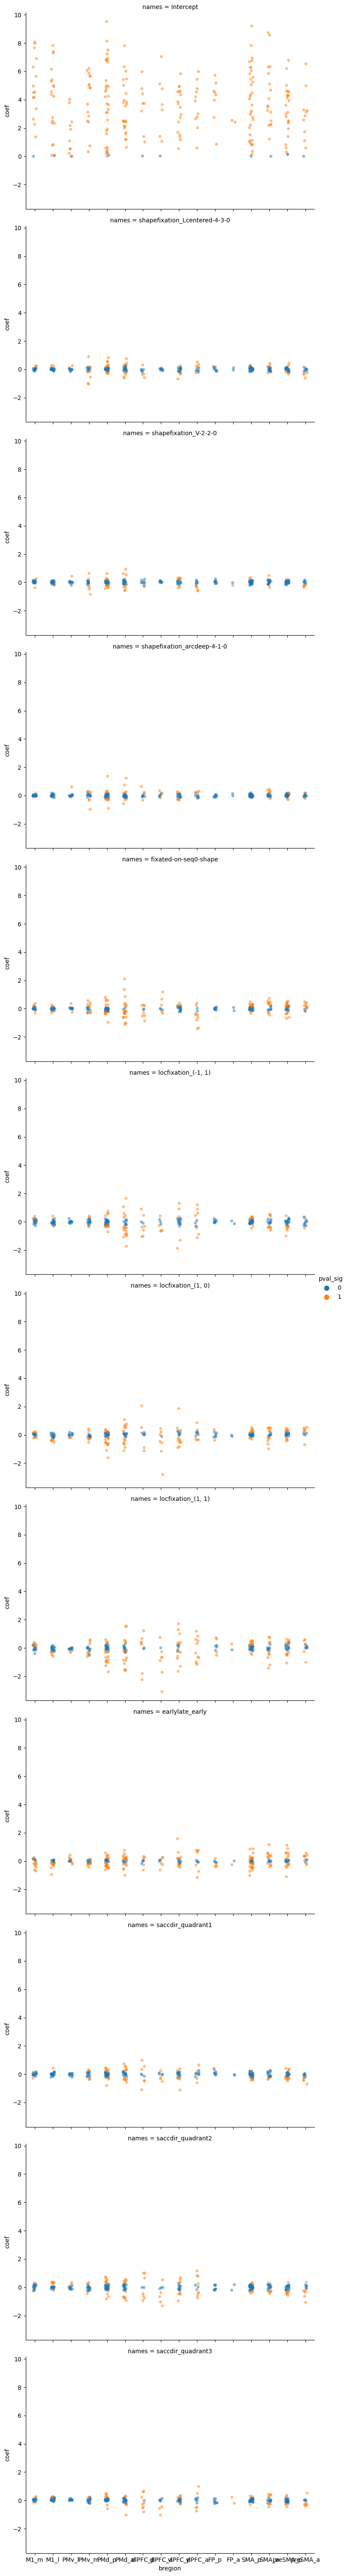

In [30]:
sns.catplot(data=lr_models, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

In [53]:
from pythonlib.tools.snstools import rotateLabel

lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
# glm_df_nointer = glm_df_new[(glm_df_new['sm-fr-avg-events'] >=1)]

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)
fig.show()

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

AttributeError: 'FacetGrid' object has no attribute 'show'

# MODEL 2

In [32]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['earlylate_early', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0', 'seen-this-shape-in-trial', 'prevshapefixation_Lcentered-4-3-0',
          'prevshapefixation_V-2-2-0', 'prevshapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'
         ]
# d_vars = ['fixated-on-seq0-shape', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
#           'shapefixation_arcdeep-4-1-0', 'shapefixation_line-8-4-0', 'locfixation_(-1, 0)',
#           'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)', 'earlylate_quartile1',
#           'earlylate_quartile2', 'earlylate_quartile3', 'earlylate_quartile4',
#           'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3', 'saccdir_quadrant4']
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [33]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', col='bregion', hue='pval_sig')

In [34]:
lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [35]:
from pythonlib.tools.snstools import rotateLabel

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

# MODEL 3

In [36]:
import pingouin as pg
import warnings
warnings.filterwarnings('default')

# for each channel, new regression model
d_vars = ['earlylate_early', 'shapefixation_Lcentered-4-3-0', 'shapefixation_V-2-2-0',
          'shapefixation_arcdeep-4-1-0',
          'fixated-on-seq0-shape', 'seqc0shape_Lcentered-4-3-0', 'seqc0shape_V-2-2-0',
          'seqc0shape_arcdeep-4-1-0',
         'locfixation_(-1, 1)', 'locfixation_(1, 0)', 'locfixation_(1, 1)',
         'saccdir_quadrant1', 'saccdir_quadrant2', 'saccdir_quadrant3'
         ]
chans = glm_df['chan'].unique()

# new plot for each dependent variable
results = []
frs = []
for c in chans:
    df_temp = glm_df[glm_df['chan']==c]
    #frs.append(np.mean(df_temp['avg-fr-sm-sqrt-post']))
    lr = pg.linear_regression(df_temp[d_vars],#df_temp[d_vars],
                         df_temp['avg-fr-sm-sqrt-post'])
    lr['chan'] = c
    lr['bregion'] = sn.sitegetterKS_map_site_to_region(c) # gets brain region from KS "site"
    lr['sm-fr-avg-events'] = np.mean(df_temp['avg-fr-sm-sqrt-post'])
    lr['sm-fr-std-events'] = np.std(df_temp['avg-fr-sm-sqrt-post'])
    results.append(lr)

lr_models = pd.concat(results).reset_index(drop=True)

lr_models['pval_sig'] = (lr_models['pval'] < 0.05)
lr_models['pval_sig'] = lr_models['pval_sig'].astype(int)

In [37]:
import seaborn as sns
#sns.relplot(data=lr_models, x='chan', y='coef',row='names', col='bregion', hue='pval_sig')

In [38]:
lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
sns.catplot(data=lr_models_nointer, x='bregion', y='coef',row='names', hue='pval_sig', aspect=1.5, alpha=0.5)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre

In [39]:
from pythonlib.tools.snstools import rotateLabel

lr_models_nointer = lr_models[(lr_models['names']!='Intercept') & (lr_models['sm-fr-avg-events'] >=1)]
# glm_df_nointer = glm_df_new[(glm_df_new['sm-fr-avg-events'] >=1)]

fig = sns.catplot(data=lr_models_nointer, x='names', y='coef', col='bregion', col_wrap=4, hue='pval_sig', alpha=0.5)
rotateLabel(fig)

/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/kgg/anaconda3/envs/ppmonkey/lib/python3.10/site-packages/seaborn/categorical.py:381: Depre